<a href="https://colab.research.google.com/github/Giovannisb/Portfolio_data_science/blob/master/Churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Churn Prediction

<p align=center>
<img src="https://st2.depositphotos.com/2673929/6809/i/450/depositphotos_68092977-stock-photo-thumb-up.jpg" width="60%"></p>

*Churn rate*, ou simplesmente *churn*, representa a taxa de evasão da sua base de clientes. Em serviços como Spotify ou Netflix, ela representaria a taxa de cancelamento de assinaturas.

Churn rate está relacionado diretamente com a receita da empresa, assim, quanto menor o valor de churn, menor é a baixa de receita de uma empresa.

#Importando os dados e as bibliotecas necessárias.

Os dados importados são de uma empresa de telecomunicações, um cenário perfeito para avaliar-mos o churn. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Apesar de não haver informações explícitas disponíves, os nomes das colunas permitem um entendimento a respeito do problema.

In [1]:
# importar os pacotes necessários
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# importar os dados
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

# ver as 5 primeiras entradas
df.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Só com a visualização das 5 primeiras linhas do dataset, já podemos fazer algumas observações como: Tipo de serviço de internet contratado pelo cliente, seu gênero, alguns outros serviços e o tipo de contrato.

In [2]:
print("Linhas:\t\t{}".format(df.shape[0]))
print("Colunas:\t{}".format(df.shape[1]))

Linhas:		7043
Colunas:	21


Como podemos verificar, as dimenções do nosso dataset são de 7043 linhas e 21 colunas.

##Vamos analisar mais a fundo o dataset.

A partir de agora irei me aprofundar na análise de dados

In [3]:
print("Dados ausentes (total):\t{}\n".format(df.isnull().sum().values.sum()))
print(df.isnull().sum() / df.shape[0])
print("\nNomes das features:\n{}\n".format(df.columns.values))
print("Valores únicos (por coluna):\n{}\n".format(df.nunique()))
print("Tipos de Variáveis (por coluna)\n{}".format(df.dtypes))

Dados ausentes (total):	0

customerID          0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

Nomes das features:
['customerID' 'gender' 'SeniorCitizen' 'Partner' 'Dependents' 'tenure'
 'PhoneService' 'MultipleLines' 'InternetService' 'OnlineSecurity'
 'OnlineBackup' 'DeviceProtection' 'TechSupport' 'StreamingTV'
 'StreamingMovies' 'Contract' 'PaperlessBilling' 'PaymentMethod'
 'MonthlyCharges' 'TotalCharges' 'Churn']

Valores únicos (por coluna):
customerID          7043
gender                 2
SeniorCitizen          2
Partner             

Como podemos observar acima, não temos nenhum dado nulo porém, temos alguns detalhes que devemos ter bastante atenção, como por exemplo, a coluna `TotalCharges` deveria ser um `float`, mas está como `string`, isso pode indicar que podemos ter algum valor nulo oculto na coluna. A coluna `costumerID` não agrega nenhuma informação, pois se trata de um identificador única para cada cliente, e a variável alvo está na coluna `Churn`, indicando a situação de churn.

Na coluna `MultipleLines`, podemos observar 3 valores distintos: 'No', 'No-phone-service' e 'yes', que significam se a pessoa tem multiplas linhas telefônicas, se ela apenas contratou uma linha e se ela não contratou nenhuma linha telefônica

In [4]:
# converter coluna TotalCharges para float
#df["TotalCharges"].astype('float32')

In [5]:
df['TotalCharges'].values

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

Ao tentar converter os dados da coluna `TotalCharges` de string para float, ocorreu um erro. Como os dados desta coluna estão como tipo string, entre aspas, alguns dados foram escritos como strings vazia, com isso, mascarando os dados nulos.

In [6]:
def converter_str_float(entrada):
    """
    Converte um objeto do tipo string em float.

    # Arguments
        entrada: string, string da coluna TotalCharges.

    # Returns
        Valor convertido em float, caso permita a conversão.
        NaN, caso o valor não seja apropriado.
    """

    try:
        return float(entrada)
    except ValueError:
        return np.nan

# criar cópia do dataframe
df_clean = df.copy()

# remover coluna costumerID
df_clean.drop("customerID", axis=1, inplace=True)

# converter as strings de TotalCharges para float
df_clean["TotalCharges"] = df_clean["TotalCharges"].apply(converter_str_float)

# verificar entradas ausentes
print("Dados ausentes em 'TotalCharges' (antes):\t{}\n".format(df_clean["TotalCharges"].isnull().sum()))

# substituir os dados ausentes pelo valor da mediana
TotalChargesMedian = df_clean.TotalCharges.median()
df_clean["TotalCharges"].fillna(TotalChargesMedian, inplace=True)

Dados ausentes em 'TotalCharges' (antes):	11



Como podemos ver, existem 11 dados ausentes na coluna.

In [7]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


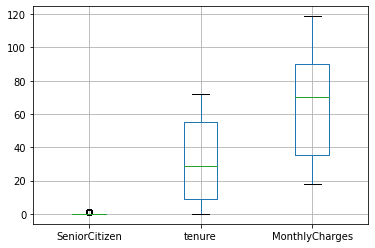

In [8]:
df.boxplot();

Observando as estatísticas dos dados, não observamos outliers e seus valores estão coesos com suas estimativas de intervalos.

Observando mais a fundo a coluna `tenure`, podemos estimar que ela se refere a quanto tempo o cliente permaneceu com a assinatura do serviço com a empresa. Como não existe nenhuma documentação sobre o dataset, iremos assumir a premissa que esse coluna se refere ao intervalode meses de assinatura.

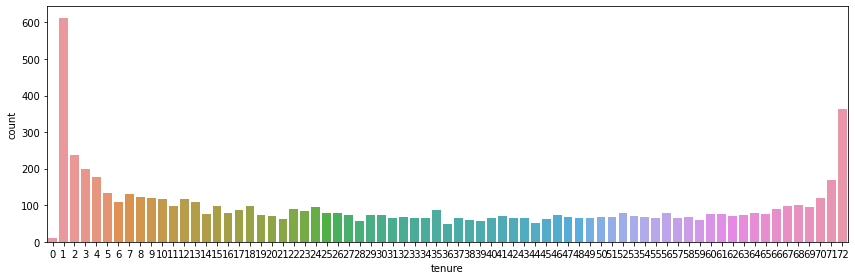

In [9]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.countplot(df['tenure'])
plt.tight_layout()

Podemos observar que há um grande número de evasões 4 primeiros meses, após esse intervalo o gráfico segue uma média e ao final dos 72 meses outro grande pico de evasões.

##Variáveis categóricas

In [10]:
df_clean.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [11]:
df_clean['MultipleLines'].unique()

array(['No phone service', 'No', 'Yes'], dtype=object)

In [12]:
df_clean['InternetService'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

In [13]:
df_clean['Contract'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [14]:
df_clean['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

Algumas colunas são preenchidas por variáveis categóricas, ou seja, valores que representam uma determinada condição e que se repetem, mais a frente, quando estivermos montando nosso modelo de Machine learning iremos refatorar nosso dataset.

##Balanceamento do dataset

Para evitar-mos algum tipo de viés na nossa análise e no nosso modelo de Machine learning, iremos observar se algumas variáveis como gênero e churn estão balanceadas.

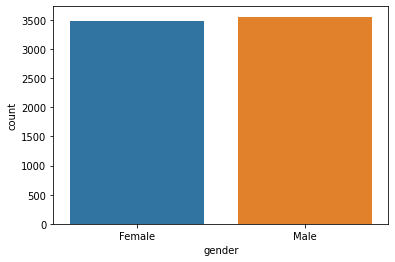

In [15]:
sns.countplot(df_clean['gender']);

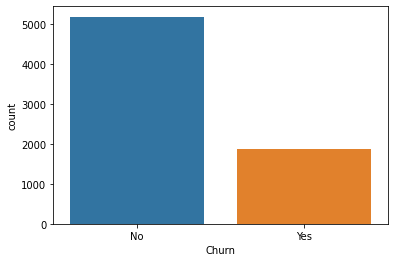

In [16]:
sns.countplot(df_clean['Churn']);

Observamos que a coluna `gender`, que se refere ao gênero do cliente, está balanceada, em contrapartida, a nossa coluna alg=vo, `Churn`, está bastante desbalanceada mas iremos corrigir isso.

##Preparação dos dados

Nesta etapa de preparação dos dados, será realizado um pré-processamento básico, apenas com a finalidade de construir um modelo base. 

As features que continham 2 labels únicos, serão processadas usando-se o `LabelEncoder`. Vale lembrar que isso inclui a variável alvo `Churn`. Na sequência, serão separadas as variáveis numéricas das categóricas. As categóricas serão transformadas em variáveis dummy, para permitir a sua utilização em todos os modelos.

In [17]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# pré processar as variáveis
binary_var = df_clean.nunique()[df_clean.nunique() == 2].keys().tolist()
num_var = [col for col in df_clean.select_dtypes(['int', 'float']).columns.tolist() if col not in binary_var]
cat_var = [col for col in df_clean.columns.tolist() if col not in binary_var + num_var]

# criar uma cópia do dataframe
df_proc = df_clean.copy()

# Label Encoding para as variáveis Binárias
le = LabelEncoder()
for i in binary_var:
    df_proc[i] = le.fit_transform(df_proc[i])

# Encoding para colunas categóricas com múltiplas classes
df_proc = pd.get_dummies(df_proc, columns=cat_var)

# ver as 5 primeiras entradas do novo dataframe
df_proc.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


##Modelo de machine learning

Com o processamento realizado na etapa anterior, os dados já podem ser usados nos modelos de machine learning.

Para podermos comparar o desempenho e melhora do modelo, criaremos um baseline simples. Não será feito nenhum ajuste nos hiperparâmetros e nem será pensado ainda em balanceamento de dados, feature engineering ou feature selection (entre outros).

In [44]:
!pip install scikit-plot -q
!pip install imbalanced-learn -q

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from imblearn.under_sampling import RandomUnderSampler

In [39]:
# separar a feature matrix da target vector
X = df_proc.drop('Churn', axis=1)
y = df_proc['Churn']

# dividir os dados entre treino e teste.
X_train, X_test, y_train, y_test = train_test_split(X, y)

Irei  estimar o score dos modelos iniciais. Para facilitar e melhorar o código, foi criada uma função `val_model`. A métrica utilizada para avaliação será `recall`. Irei criar uma função chamada val_model para facilitar nossa validação de qual será o melhor modelo.

In [20]:
def val_model(X, y, clf, quite=False):
    """
    Realiza cross-validation com os dados de treino para determinado modelo.

    # Arguments
        X: DataFrame, contém as variáveis independetes.
        y: Series, vetor contendo a variável alvo.
        clf: modelo classificador do Scikit-learn.
        quite: bool, indicando se a função deve imprimir os resultados ou não.

    # Returns
        float, média dos scores da cross-validation.
    """
    
    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring='recall')

    if quite == False:
        print("Recall: {:.2f} (+/- {:.2f})".format(scores.mean(), scores.std()))
    
    return scores.mean()

In [21]:
svc = SVC()
lgbm = LGBMClassifier()
sgdc = SGDClassifier()
dtc = DecisionTreeClassifier()
lr = LogisticRegression()
xgbc = XGBClassifier()
rfc = RandomForestClassifier()
vt = VotingClassifier(estimators=[('svc', svc),('lgbm', lgbm),('sgdc', sgdc),('dtc', dtc),('lr',lr),('xgbc',xgbc),('rfc',rfc)])

models = []
recall = []

for model in (svc, lgbm, sgdc, dtc, lr, xgbc, rfc, vt):
  score_baseline = val_model(X_train, y_train, model)

Recall: 0.47 (+/- 0.05)
Recall: 0.49 (+/- 0.04)
Recall: 0.48 (+/- 0.06)
Recall: 0.51 (+/- 0.02)
Recall: 0.53 (+/- 0.06)
Recall: 0.50 (+/- 0.05)
Recall: 0.46 (+/- 0.02)
Recall: 0.50 (+/- 0.04)


O modelo com melhor recall foi o de `Decision tree classifier`. Irei redefinir os dados de teste e de treino para não correr risco de ter viés no nosso modelo. 

In [48]:
X = df_proc.drop('Churn', axis=1)
y = df_proc['Churn']

# dividir os dados entre treino e teste.
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [40]:
#  padronizar os  dados,
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# Para quem quiser, pesquisa sobre SMOTE
# oversample = SMOTE()
# X_train, y_train = oversample.fit_sample(X_train, y_train)

rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Agora irei utilizzar a técnica de grid search, para testar e descobrir qual o melhor setup de hiperparâmetros é o que irá mostrar o melhor resultado.

In [49]:
# Create a dictionary of all the parameter options  
parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4,6,8,12]
    }

# Conduct Parameter Optmization With Pipeline
# Create a grid search object
clf = GridSearchCV(dtc, parameters)
clf.fit(X_train, y_train)

print("Melhor: {} usando {}".format(clf.best_score_, clf.best_params_))

Melhor: 0.7885301095152089 usando {'criterion': 'gini', 'max_depth': 4}


Nosso melhor score foi de 0.789 utilizando os hiperparâmetros `criterion` como gini e `max_depth` = 4.

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1300
           1       0.63      0.51      0.57       461

    accuracy                           0.79      1761
   macro avg       0.73      0.70      0.72      1761
weighted avg       0.78      0.79      0.79      1761

AUC: 0.7036



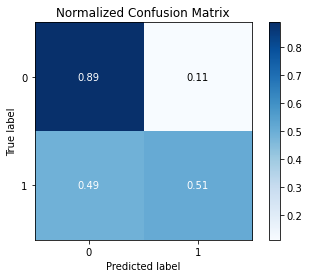

In [50]:
model = DecisionTreeClassifier(criterion='gini', max_depth=4)
model.fit(X_train, y_train)

# fazer a previsão
y_pred = model.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

# imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

# plotar matriz de confusão
plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

##Considerações finais

O nosso modelo conseguiu identificar 84% dos casos de churn negativo e 51% dos casos de churn positivos. Como métrica de avaliação, usamos a pontuação `AUC`, que é a mais utilizada nas principais competições do kaggle, nossa pontuação foi de 0.70, que considero um bom resultado.